In [1]:
#IMPORTS
import pm4py
import sklearn
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from pm4py.algo.transformation.log_to_features import algorithm as log_to_features
from itertools import product
from torchmetrics.classification import BinaryF1Score, BinaryConfusionMatrix
from torchmetrics.regression import R2Score, MeanAbsoluteError
import matplotlib.pyplot as plt

# Prepare the Data
The code below is used to generate the CVS file. You can also skip running it and instead load the CSV directly a few cells below.

First, make sure the permit log is in the current directory, then run the code below

In [2]:
travel_permits = pm4py.read_xes('PermitLog.xes.gz')

parsing log, completed traces ::   0%|          | 0/7065 [00:00<?, ?it/s]

First, we make sure we have the prefixes we need, we just want the events leading up to 'Start trip'

In [3]:
travel_prefixes = pm4py.filtering.filter_prefixes(travel_permits, 'Start trip')

In [4]:
#quick check to see if we got what we wanted
i = 39
for e in travel_permits[i]:
    print(e['concept:name'])
print() 
for e in travel_prefixes[i]:
    print(e['concept:name'])

Permit SUBMITTED by EMPLOYEE
Permit FINAL_APPROVED by SUPERVISOR
Start trip
End trip
Declaration SUBMITTED by EMPLOYEE
Declaration FINAL_APPROVED by SUPERVISOR
Request Payment
Payment Handled

Permit SUBMITTED by EMPLOYEE
Permit FINAL_APPROVED by SUPERVISOR


Check if a declaration was submitted before the trip started

In [5]:
decl_bools = np.zeros((7065,1))

for i,t in enumerate(travel_prefixes):
    for e in t:
        if e['concept:name'] == "Declaration SUBMITTED by EMPLOYEE":
            decl_bools[i,0] = 1
            
decl_bools.shape

(7065, 1)

Now extract the features we are interested in from the prefixes:

In [6]:
data_regr, _ = log_to_features.apply(travel_prefixes, parameters={'num_tr_attr': ["RequestedBudget","OverspentAmount"]})
data_class, _ = log_to_features.apply(travel_prefixes, parameters={'num_tr_attr': ["RequestedBudget","Overspent"]})

data_regre = np.array(data_regr).round(2)
data_class = np.array(data_class).round(2)
data_class.shape

(7065, 2)

However, we still need trip duration, which we will need to compute manually. We will use number of days to denote the duration

In [7]:
trip_durations = []
for trace in travel_permits:
    for e in trace:
        if e['concept:name'] == "Start trip": #note the time the trip started
            start_time = e['time:timestamp']
        elif e['concept:name'] == "End trip": #note the time the trip ended
            end_time = e['time:timestamp']
            break
    trip_durations.append((end_time-start_time).days) #save the trip duration in days
    
trip_durations = np.array(trip_durations).reshape((-1,1))
trip_durations.shape

(7065, 1)

And we do the same in order to get the duration between the permit being submitted and the permit being approved

In [8]:
perm_durations = []
for trace in travel_permits:
    started = False
    for e in trace:
        if e['concept:name'].startswith("Permit") and not started: #start time is the first time permit is mentioned
            started = True
            start_time = e['time:timestamp']
            end_time = e['time:timestamp']
        elif e['concept:name'].startswith("Permit"): #end time is the last time permit is mentioned
            end_time = e['time:timestamp']
    perm_durations.append((end_time-start_time).days) #save duration of permit handling in days
    
perm_durations = np.array(perm_durations).reshape((-1,1))
perm_durations.shape

(7065, 1)

Now we merge all the features we extracted into one dataframe

In [9]:
final_data_regr = np.absolute(np.concatenate((decl_bools, trip_durations, perm_durations, data_regr), axis=1))
final_data_class = np.concatenate((decl_bools, trip_durations, perm_durations, data_class), axis=1)
final_data_class.shape

(7065, 5)

Some exploration of the data we have now:

In [10]:
pd.DataFrame(data=final_data_class[:10,:])

,0,1,2,3,4
0,0.0,0.0,0.0,41.61,0.0
1,0.0,31.0,0.0,795.54,0.0
2,0.0,0.0,0.0,51.79,1.0
3,0.0,21.0,0.0,0.00,0.0
4,0.0,364.0,0.0,6020.79,0.0
5,0.0,2.0,0.0,245.06,0.0
6,0.0,6.0,0.0,0.00,0.0
7,0.0,3.0,0.0,1015.98,0.0
8,0.0,5.0,0.0,0.00,0.0
9,0.0,5.0,0.0,156.96,0.0


We can now save the data to CSV:

In [11]:
np.savetxt('ML_data_class.csv', final_data_class, delimiter=',')
np.savetxt('ML_data_regr.csv', final_data_regr, delimiter=',')

# Load the CSV
Or skip the below cell if you already ran the above cells

In [12]:
final_data_class = np.genfromtxt('ML_data_class.csv',delimiter=',')
final_data_regr = np.genfromtxt('ML_data_regr.csv',delimiter=',')
final_data_regr.shape

(7065, 5)

# Train the ML model
First, we split into train, test and validation sets. We do not shuffle because for process mining it is important that the validation and test sets are further in the future than the training set. The training set is 80%, validation 10%, and test set 10%.

## Classification

In [13]:
X_train, X_valtest, y_train, y_valtest = sklearn.model_selection.train_test_split(final_data_class[:,:-1], final_data_class[:,-1], 
                                                                                  train_size=0.8, shuffle=False)
X_val, X_test, y_val, y_test = sklearn.model_selection.train_test_split(X_valtest, y_valtest, train_size=0.5, shuffle=False)

In [18]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [20]:
## Model Definition ##
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.input_layer = torch.nn.Linear(4,16)
        self.hidden_layer = torch.nn.Linear(16, 16)
        self.output_layer = torch.nn.Linear(16, 1)
        
    def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden_layer(x)
        x = torch.sigmoid(self.output_layer(x))
        return x

In [22]:
## Training ##
class Trainer():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 epochs: int,
                 mean_train_losses,
                 mean_val_losses
                 ):
        
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.epochs = epochs
        self.mean_train_losses = mean_train_losses
        self.mean_val_losses = mean_val_losses

    def run_trainer(self):
        self.model = self.model.float()
        for epoch in tqdm(range(self.epochs)):
            
            self.model.train()  # train mode
            train_losses=[]
            for batch in range(X_train.shape[0]):
                x,y=torch.as_tensor(X_train[batch]), torch.as_tensor(y_train[batch])
                input, target = x.to(self.device), y.to(self.device).reshape((-1,1)).squeeze(-1)  # send to device (GPU or CPU)
                self.optimizer.zero_grad()  # zerograd the parameters
                out = self.model(input.float())  # one forward pass
                loss = self.criterion(out, target.float()).cpu()  # calculate loss

                train_losses.append(float(loss))
                 
                loss.backward()  # one backward pass
                self.optimizer.step()  # update the parameters

            self.mean_train_losses.append(np.mean(train_losses))
            
            val_losses=[]
            for batch in range(X_val.shape[0]):
                self.model.eval()
                x,y=torch.as_tensor(X_val[batch]), torch.as_tensor(y_val[batch])
                input, target = x.to(self.device), y.to(self.device).reshape((-1,1)).squeeze(-1)  # send to device (GPU or CPU)
                self.optimizer.zero_grad()  # zerograd the parameters
                out = self.model(input.float())  # one forward pass
                loss = self.criterion(out, target.float()).cpu()  # calculate loss

                val_losses.append(float(loss))
                
            print(f'EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}', end=' ')
            print(f"TRAIN LOSS: {np.mean(train_losses):.4f}")
            print(f"VAL LOSS: {np.mean(val_losses):.4f}")
            self.mean_val_losses.append(np.mean(val_losses))


    def test(self):
        model = self.model.to("cpu")
        model.eval()
        model = model.float()
        test_losses=[]
        y_test_pred=[]
        for batch in range(X_test.shape[0]):
            x,y=torch.as_tensor(X_test[batch]).clone().detach().cpu(), torch.as_tensor(y_test[batch]).clone().detach().cpu()
            input, target = x.to(self.device), y.to(self.device).reshape((-1,1)).squeeze(-1)  # send to device (GPU or CPU)
            self.optimizer.zero_grad()  # zerograd the parameters
            out = model(input.float().cpu())  # one forward pass
            loss = self.criterion(out.clone().detach().cpu(), target.float().clone().detach().cpu())  # calculate loss
            y_test_pred.append(out.clone().detach().numpy())

            test_losses.append(float(loss))
        return y_test_pred
                
        print(f"LOSS: {np.mean(test_losses):.4f}")

In [23]:
model_class = Model().to(device)
criterion_class = torch.nn.BCELoss()
optimizer_class = torch.optim.Adam(model_class.parameters(), lr=0.001)
trainer_class = Trainer(model=model_class,
                  device=device,
                  criterion=criterion_class,
                  optimizer=optimizer_class,
                  epochs=20,
                  mean_train_losses=[],
                  mean_val_losses=[]
                 )
trainer_class.run_trainer()
class_pred = trainer_class.test()

  5%|████▏                                                                              | 1/20 [00:13<04:21, 13.75s/it]

EPOCH: 01/20 TRAIN LOSS: 21.2121
VAL LOSS: 2.7679


 10%|████████▎                                                                          | 2/20 [00:28<04:17, 14.30s/it]

EPOCH: 02/20 TRAIN LOSS: 1.0421
VAL LOSS: 0.5957


 15%|████████████▍                                                                      | 3/20 [00:41<03:57, 13.96s/it]

EPOCH: 03/20 TRAIN LOSS: 0.6690
VAL LOSS: 0.6007


 20%|████████████████▌                                                                  | 4/20 [00:56<03:45, 14.10s/it]

EPOCH: 04/20 TRAIN LOSS: 0.6239
VAL LOSS: 0.5780


 25%|████████████████████▊                                                              | 5/20 [01:10<03:33, 14.21s/it]

EPOCH: 05/20 TRAIN LOSS: 0.6150
VAL LOSS: 0.5754


 30%|████████████████████████▉                                                          | 6/20 [01:24<03:15, 13.96s/it]

EPOCH: 06/20 TRAIN LOSS: 0.6123
VAL LOSS: 0.5748


 35%|█████████████████████████████                                                      | 7/20 [01:37<03:00, 13.86s/it]

EPOCH: 07/20 TRAIN LOSS: 0.6075
VAL LOSS: 0.5719


 40%|█████████████████████████████████▏                                                 | 8/20 [01:51<02:45, 13.78s/it]

EPOCH: 08/20 TRAIN LOSS: 0.6046
VAL LOSS: 0.5747


 45%|█████████████████████████████████████▎                                             | 9/20 [02:04<02:30, 13.71s/it]

EPOCH: 09/20 TRAIN LOSS: 0.6028
VAL LOSS: 0.5769


 50%|█████████████████████████████████████████                                         | 10/20 [02:18<02:17, 13.71s/it]

EPOCH: 10/20 TRAIN LOSS: 0.6007
VAL LOSS: 0.5753


 55%|█████████████████████████████████████████████                                     | 11/20 [02:32<02:03, 13.67s/it]

EPOCH: 11/20 TRAIN LOSS: 0.6006
VAL LOSS: 0.5773


 60%|█████████████████████████████████████████████████▏                                | 12/20 [02:45<01:49, 13.65s/it]

EPOCH: 12/20 TRAIN LOSS: 0.6005
VAL LOSS: 0.5742


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [02:59<01:35, 13.62s/it]

EPOCH: 13/20 TRAIN LOSS: 0.6007
VAL LOSS: 0.5717


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [03:13<01:21, 13.64s/it]

EPOCH: 14/20 TRAIN LOSS: 0.6010
VAL LOSS: 0.5744


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [03:26<01:08, 13.62s/it]

EPOCH: 15/20 TRAIN LOSS: 0.6004
VAL LOSS: 0.5713


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [03:40<00:54, 13.59s/it]

EPOCH: 16/20 TRAIN LOSS: 0.6009
VAL LOSS: 0.5752


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [03:53<00:40, 13.57s/it]

EPOCH: 17/20 TRAIN LOSS: 0.6002
VAL LOSS: 0.5734


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [04:07<00:27, 13.54s/it]

EPOCH: 18/20 TRAIN LOSS: 0.6005
VAL LOSS: 0.5722


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [04:20<00:13, 13.55s/it]

EPOCH: 19/20 TRAIN LOSS: 0.6010
VAL LOSS: 0.5732


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [04:34<00:00, 13.72s/it]

EPOCH: 20/20 TRAIN LOSS: 0.6006
VAL LOSS: 0.5729


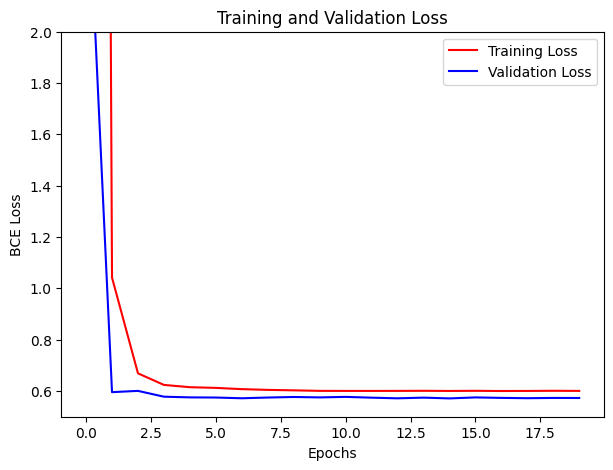

In [37]:
plt.figure(0, figsize=(7,5))
plt.plot(trainer_class.mean_train_losses, 'red')
plt.plot(trainer_class.mean_val_losses, 'blue')
plt.ylim(0.5,2)
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("BCE Loss")
plt.legend(["Training Loss","Validation Loss"])

In [25]:
metric = BinaryF1Score(threshold=0.5)
metric(torch.as_tensor(1-np.array(class_pred)[:,0]), torch.as_tensor(1-y_test))

tensor(0.9239)

In [26]:
metric = BinaryConfusionMatrix()
metric(torch.as_tensor(np.array(class_pred)[:,0]), torch.as_tensor(y_test))

tensor([[607,   0],
        [100,   0]])

## Regression

In [27]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [28]:
## Model Definition ##
class Model_Regress(torch.nn.Module):
    def __init__(self):
        super(Model_Regress, self).__init__()
        self.input_layer = torch.nn.Linear(4,16)
        self.hidden_layer = torch.nn.Linear(16, 16)
        self.output_layer = torch.nn.Linear(16, 1)
        
    def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden_layer(x)
        x = self.output_layer(x)
        return x

In [29]:
X_train, X_valtest, y_train, y_valtest = sklearn.model_selection.train_test_split(final_data_regr[:,:-1], final_data_regr[:,-1], 
                                                                                 train_size=0.8, shuffle=False)
X_val, X_test, y_val, y_test = sklearn.model_selection.train_test_split(X_valtest, y_valtest, train_size=0.5, shuffle=False)
model_regress = Model_Regress().to(device)
criterion_regress = torch.nn.L1Loss()
optimizer_regress = torch.optim.Adam(model_regress.parameters(), lr=0.001)
trainer_regress = Trainer(model=model_regress,
                  device=device,
                  criterion=criterion_regress,
                  optimizer=optimizer_regress,
                  epochs=20,
                  mean_train_losses=[],
                  mean_val_losses=[]
                 )

trainer_regress.run_trainer()
regress_pred = trainer_regress.test()

  5%|████▏                                                                              | 1/20 [00:13<04:14, 13.39s/it]

EPOCH: 01/20 TRAIN LOSS: 585.9981
VAL LOSS: 285.5611


 10%|████████▎                                                                          | 2/20 [00:27<04:04, 13.57s/it]

EPOCH: 02/20 TRAIN LOSS: 583.6828
VAL LOSS: 285.2558


 15%|████████████▍                                                                      | 3/20 [00:40<03:51, 13.59s/it]

EPOCH: 03/20 TRAIN LOSS: 583.2457
VAL LOSS: 285.2110


 20%|████████████████▌                                                                  | 4/20 [00:54<03:37, 13.57s/it]

EPOCH: 04/20 TRAIN LOSS: 582.9722
VAL LOSS: 285.1320


 25%|████████████████████▊                                                              | 5/20 [01:07<03:23, 13.54s/it]

EPOCH: 05/20 TRAIN LOSS: 583.0312
VAL LOSS: 285.0620


 30%|████████████████████████▉                                                          | 6/20 [01:21<03:09, 13.51s/it]

EPOCH: 06/20 TRAIN LOSS: 582.7101
VAL LOSS: 284.7158


 35%|█████████████████████████████                                                      | 7/20 [01:34<02:54, 13.45s/it]

EPOCH: 07/20 TRAIN LOSS: 582.6848
VAL LOSS: 284.6342


 40%|█████████████████████████████████▏                                                 | 8/20 [01:47<02:41, 13.43s/it]

EPOCH: 08/20 TRAIN LOSS: 582.6200
VAL LOSS: 284.5342


 45%|█████████████████████████████████████▎                                             | 9/20 [02:01<02:27, 13.45s/it]

EPOCH: 09/20 TRAIN LOSS: 582.4970
VAL LOSS: 284.4511


 50%|█████████████████████████████████████████                                         | 10/20 [02:14<02:14, 13.42s/it]

EPOCH: 10/20 TRAIN LOSS: 582.5473
VAL LOSS: 284.3891


 55%|█████████████████████████████████████████████                                     | 11/20 [02:28<02:01, 13.47s/it]

EPOCH: 11/20 TRAIN LOSS: 582.4654
VAL LOSS: 284.2865


 60%|█████████████████████████████████████████████████▏                                | 12/20 [02:41<01:47, 13.45s/it]

EPOCH: 12/20 TRAIN LOSS: 582.4505
VAL LOSS: 284.2918


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [02:55<01:33, 13.42s/it]

EPOCH: 13/20 TRAIN LOSS: 582.4564
VAL LOSS: 284.3647


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [03:08<01:20, 13.43s/it]

EPOCH: 14/20 TRAIN LOSS: 582.4673
VAL LOSS: 284.2686


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [03:21<01:07, 13.42s/it]

EPOCH: 15/20 TRAIN LOSS: 582.4737
VAL LOSS: 284.2845


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [03:35<00:53, 13.43s/it]

EPOCH: 16/20 TRAIN LOSS: 582.3963
VAL LOSS: 284.2747


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [03:48<00:40, 13.39s/it]

EPOCH: 17/20 TRAIN LOSS: 582.4369
VAL LOSS: 284.2751


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [04:02<00:26, 13.40s/it]

EPOCH: 18/20 TRAIN LOSS: 582.4495
VAL LOSS: 284.3037


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [04:15<00:13, 13.42s/it]

EPOCH: 19/20 TRAIN LOSS: 582.3459
VAL LOSS: 284.2511


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [04:28<00:00, 13.45s/it]

EPOCH: 20/20 TRAIN LOSS: 582.2307
VAL LOSS: 284.3815


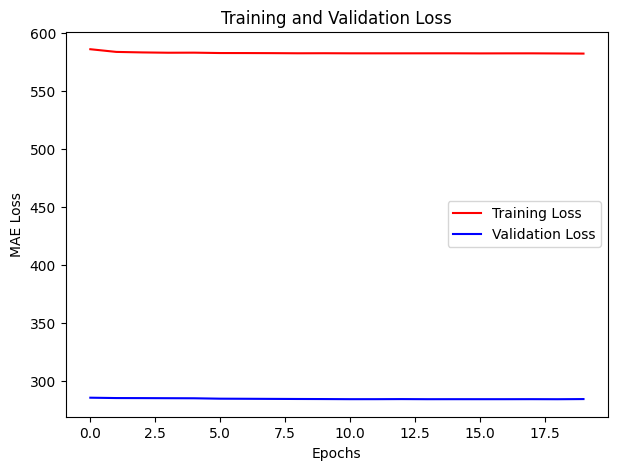

In [38]:
plt.figure(0, figsize=(7,5))
plt.plot(trainer_regress.mean_train_losses, 'red')
plt.plot(trainer_regress.mean_val_losses, 'blue')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MAE Loss")
plt.legend(["Training Loss","Validation Loss"])

In [31]:
metric = R2Score()
metric(torch.as_tensor(np.array(regress_pred)[:,0]), torch.as_tensor(y_test))

tensor(0.1108)

In [32]:
metric = MeanAbsoluteError()
metric(torch.as_tensor(np.array(regress_pred)[:,0]), torch.as_tensor(y_test))

tensor(620.0386)